# PyTorch Basics and Your First Neural Network

**Goal**: Learn PyTorch syntax and best practices for deep learning development

In this notebook, you'll get hands-on experience with:
1. **PyTorch fundamentals**: Creating tensors, computing gradients, and updating parameters
2. **Building neural networks**: Implementing an MLP from scratch
3. **Training workflow**: Data loading, training loops, and tracking performance

You already understand the theory behind neural networks. Now let's see how to implement them in PyTorch!

In [303]:
# Import necessary libraries
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

print(f"PyTorch version: {torch.__version__}")
print(f"Device available: {'cuda' if torch.cuda.is_available() else 'cpu'}")

PyTorch version: 2.9.0+cpu
Device available: cpu


---
## Part 1: PyTorch Fundamentals

Before building neural networks, let's understand the basic building blocks of PyTorch.

### Creating Tensors

Tensors are the fundamental data structure in PyTorch - think of them as multidimensional arrays with extra capabilities for deep learning.

In [304]:
# Create a simple data point (this represents our input)
x = torch.tensor([2.0, 3.0, 1.5])
print(f"Data x: {x}")
print(f"Shape: {x.shape}")

Data x: tensor([2.0000, 3.0000, 1.5000])
Shape: torch.Size([3])


### Parameters That We'll Optimize

In deep learning, we have **parameters** (weights and biases) that we want to optimize. We tell PyTorch to track gradients for these by setting `requires_grad=True`.

In [305]:
# Create parameters - these are what we'll update during training
w = torch.tensor([0.5, -0.3, 0.8], requires_grad=True)  # weights
b = torch.tensor([0.1], requires_grad=True)              # bias

print(f"Weights w: {w}")
print(f"Bias b: {b}")
print(f"\nDoes w track gradients? {w.requires_grad}")
print(f"Does x track gradients? {x.requires_grad}")

Weights w: tensor([ 0.5000, -0.3000,  0.8000], requires_grad=True)
Bias b: tensor([0.1000], requires_grad=True)

Does w track gradients? True
Does x track gradients? False


Notice that `x` does **not** track gradients - it's our data, not a parameter we want to optimize.

### Computing a Simple Expression

Let's compute a simple linear transformation: **d = x · w + b**

This is the basic operation inside every neural network layer!

In [306]:
# Compute the expression: d = x*w + b
d = torch.dot(x, w) + b  # or equivalently: (x * w).sum() + b

print(f"Result d: {d}")
print(f"Result d (as number): {d.item():.4f}")

Result d: tensor([1.4000], grad_fn=<AddBackward0>)
Result d (as number): 1.4000


### Computing Gradients with Backpropagation

Now comes the magic of PyTorch: **automatic differentiation**. We can compute gradients of `d` with respect to our parameters automatically!

In [307]:
# Compute gradients of d with respect to w and b
d.backward()

print("Gradients after backward():")
print(f"∂d/∂w = {w.grad}")
print(f"∂d/∂b = {b.grad}")

Gradients after backward():
∂d/∂w = tensor([2.0000, 3.0000, 1.5000])
∂d/∂b = tensor([1.])


**Understanding the gradients**:
- `∂d/∂w` tells us how much `d` changes when we change each weight
- Notice that `∂d/∂w` equals `x` - this makes sense mathematically!
- `∂d/∂b = 1` because `d` increases by exactly 1 when we increase `b` by 1

### Updating Parameters to Increase d

Let's say we want to **maximize** `d`. We can update our parameters in the direction of the gradient.

In [308]:
print(f"Before update: d = {d.item():.4f}")
print(f"Before update: w = {w.data}")
print(f"Before update: b = {b.data}")

# To increase d, we move in the direction of the gradient
learning_rate = 0.1

with torch.no_grad():  # Disable gradient tracking for the update itself
    w += learning_rate * w.grad  # Move w in direction that increases d
    b += learning_rate * b.grad  # Move b in direction that increases d

    # IMPORTANT: Zero out gradients for next iteration
    w.grad.zero_()
    b.grad.zero_()

print(f"\nAfter update: w = {w.data}")
print(f"After update: b = {b.data}")

Before update: d = 1.4000
Before update: w = tensor([ 0.5000, -0.3000,  0.8000])
Before update: b = tensor([0.1000])

After update: w = tensor([0.7000, 0.0000, 0.9500])
After update: b = tensor([0.2000])


In [309]:
# Let's verify that d increased
d_new = torch.dot(x, w) + b
print(f"\nNew d = {d_new.item():.4f}")
print(f"Change in d = {(d_new - d).item():.4f} (positive means we increased d!)")


New d = 3.0250
Change in d = 1.6250 (positive means we increased d!)


✅ We successfully increased `d` by updating our parameters!

**Key PyTorch patterns you just learned**:
1. Use `requires_grad=True` for parameters you want to optimize
2. Call `.backward()` to compute gradients
3. Use `with torch.no_grad():` when updating parameters
4. Always zero gradients with `.grad.zero_()` after updating

### 🔧 Mini-Exercise: Experiment with the Update

**TODO**: Go back to the update cell and try:
1. Change `learning_rate` to `0.5` - does `d` increase more?
2. Change the `+=` to `-=` in the update - what happens to `d`?
3. Run the update cell multiple times - does `d` keep increasing?

⏱️ ~5 minutes

---
## Part 2: Building Your First Neural Network

Now let's apply what we learned to build a complete neural network and train it on real data!

### Step 1: Load and Prepare the Data

We'll use the famous Iris dataset, but only two classes to keep it simple (binary classification).

In [310]:
# Load Iris dataset
iris = load_iris()
X = iris.data  # 4 features: sepal length, sepal width, petal length, petal width
y = iris.target

# Use only two classes (0 and 1) - binary classification
mask = y < 2
X = X[mask]
y = y[mask]

print(f"Dataset shape: {X.shape}")
print(f"Number of samples: {len(X)}")
print(f"Number of features: {X.shape[1]}")
print(f"Classes: {np.unique(y)}")

Dataset shape: (100, 4)
Number of samples: 100
Number of features: 4
Classes: [0 1]


### Step 2: Split into Train and Validation Sets

**Best Practice #1**: Always keep a validation set to monitor if your model is overfitting!

In [311]:
# Split into train and validation (80/20 split)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")

Training samples: 80
Validation samples: 20


### Step 3: Normalize the Data

**Best Practice #2**: Normalize your input features so they have similar scales. This helps training converge faster!

In [312]:
# Fit scaler on training data only
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)  # Use training statistics on validation

print(f"Feature means after scaling: {X_train.mean(axis=0)}")
print(f"Feature stds after scaling: {X_train.std(axis=0)}")

Feature means after scaling: [-3.67622599e-15 -3.74700271e-17  1.80411242e-16 -3.49720253e-16]
Feature stds after scaling: [1. 1. 1. 1.]


### Step 4: Convert to PyTorch Tensors

PyTorch works with tensors, not NumPy arrays.

In [313]:
# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train).unsqueeze(1)  # Shape: (n, 1)

X_val_tensor = torch.FloatTensor(X_val)
y_val_tensor = torch.FloatTensor(y_val).unsqueeze(1)  # Shape: (n, 1)

print(f"X_train shape: {X_train_tensor.shape}")  # (80, 4)
print(f"y_train shape: {y_train_tensor.shape}")  # (80, 1)

X_train shape: torch.Size([80, 4])
y_train shape: torch.Size([80, 1])


### Exercise 1: Change the Number of Hidden Neurons

**TODO**: Modify `hidden_dim` to either 16 or 4, then retrain the model.

**Questions to answer**:
- How does this affect the total number of parameters?
- Does the model train faster or slower?
- What is the final validation accuracy?

⏱️ ~5 minutes

### Exercise 2: Experiment with Learning Rate

**TODO**: Try different learning rates: 0.01 (smaller) or 0.5 (larger).

**Questions to answer**:
- How does training speed change?
- Does the loss converge smoothly or oscillate?
- What happens if the learning rate is too large?

⏱️ ~5 minutes

### Exercise 3: Train for More Epochs

**TODO**: Increase `num_epochs` to 500.

**Questions to answer**:
- Does the model continue to improve?
- Do you observe any overfitting (validation loss increasing while training loss decreases)?
- What is the final validation accuracy compared to 200 epochs?

⏱️ ~5 minutes

### Exercise 4: Try a Different Activation Function

**TODO**: Replace `nn.Sigmoid()` with `nn.ReLU()` for the **hidden layer only** (keep sigmoid for the output layer).

**Questions to answer**:
- How does this affect training speed and final accuracy?
- Does the loss curve look different?
- Which activation function works better for this dataset?

**Hint**: ReLU is defined as `max(0, x)` and is commonly used in modern neural networks.

⏱️ ~5 minutes

### Step 5: Define the Neural Network Architecture

Let's build an MLP with:
- **Input layer**: 4 features (from Iris dataset)
- **Hidden layer**: 8 neurons with sigmoid activation
- **Output layer**: 1 neuron with sigmoid activation (for binary classification)

Architecture: `4 → 8 → 1`

In [314]:
class SimpleMLPModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SimpleMLPModel, self).__init__()

        # Define layers
        self.layer1 = nn.Linear(input_dim, hidden_dim)   # 4 → 8
        self.activation1 = nn.Sigmoid()                   # Sigmoid activation
        self.layer2 = nn.Linear(hidden_dim, output_dim)  # 8 → 1
        self.activation2 = nn.Sigmoid()                   # Output activation

    def forward(self, x):
        # Forward pass: define how data flows through the network
        x = self.layer1(x)        # Linear transformation: (batch, 4) → (batch, 8)
        x = self.activation1(x)   # Apply sigmoid: (batch, 8) → (batch, 8)
        x = self.layer2(x)        # Linear transformation: (batch, 8) → (batch, 1)
        x = self.activation2(x)   # Apply sigmoid: (batch, 1) → (batch, 1)
        return x

# Create the model
input_dim = 4    # 4 features in Iris dataset
hidden_dim = 8 # 8 neurons in hidden layer
output_dim = 1   # 1 output for binary classification

model = SimpleMLPModel(input_dim, hidden_dim, output_dim)
print(model)

SimpleMLPModel(
  (layer1): Linear(in_features=4, out_features=8, bias=True)
  (activation1): Sigmoid()
  (layer2): Linear(in_features=8, out_features=1, bias=True)
  (activation2): Sigmoid()
)


### Step 6: Count the Number of Parameters

**Best Practice #3**: Always know how many parameters your model has. This helps you understand model capacity and avoid overfitting on small datasets.

Let's count:
- **Layer 1**: (4 × 8) weights + 8 biases = 32 + 8 = 40 parameters
- **Layer 2**: (8 × 1) weights + 1 bias = 8 + 1 = 9 parameters
- **Total**: 40 + 9 = 49 parameters

In [315]:
# Count parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

total_params = count_parameters(model)
print(f"Total trainable parameters: {total_params}")

# Let's verify by looking at each layer
print("\nParameters per layer:")
for name, param in model.named_parameters():
    print(f"{name:20s} | Shape: {str(param.shape):15s} | Count: {param.numel()}")

Total trainable parameters: 49

Parameters per layer:
layer1.weight        | Shape: torch.Size([8, 4]) | Count: 32
layer1.bias          | Shape: torch.Size([8]) | Count: 8
layer2.weight        | Shape: torch.Size([1, 8]) | Count: 8
layer2.bias          | Shape: torch.Size([1]) | Count: 1


### Step 7: Define Loss Function and Optimizer

For binary classification:
- **Loss**: Binary Cross-Entropy (BCE)
- **Optimizer**: Stochastic Gradient Descent (SGD)

In [316]:
# Binary Cross-Entropy Loss
criterion = nn.BCELoss()

# Gradient Descent optimizer
learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

print(f"Loss function: {criterion}")
print(f"Optimizer: {optimizer}")

Loss function: BCELoss()
Optimizer: SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.1
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)


### Step 8: The Training Loop

**Best Practice #4**: Track both training and validation loss to detect overfitting.

Since you requested "simple gradient descent on the whole data", we'll update using the entire training set at once (full batch gradient descent).

In [317]:
# Training configuration
num_epochs = 200

# Lists to store losses for plotting
train_losses = []
val_losses = []

print("Starting training...\n")

for epoch in range(num_epochs):
    # ========== TRAINING ==========
    model.train()  # Set model to training mode

    # Forward pass on entire training set
    train_predictions = model(X_train_tensor)  # Shape: (80, 1)
    train_loss = criterion(train_predictions, y_train_tensor)

    # Backward pass
    optimizer.zero_grad()  # Clear previous gradients
    train_loss.backward()  # Compute gradients
    optimizer.step()       # Update parameters

    # ========== VALIDATION ==========
    model.eval()  # Set model to evaluation mode

    with torch.no_grad():  # Don't compute gradients for validation
        val_predictions = model(X_val_tensor)
        val_loss = criterion(val_predictions, y_val_tensor)

    # Store losses
    train_losses.append(train_loss.item())
    val_losses.append(val_loss.item())

    # Print progress every 20 epochs
    if (epoch + 1) % 20 == 0:
        print(f"Epoch [{epoch+1:3d}/{num_epochs}] | "
              f"Train Loss: {train_loss.item():.4f} | "
              f"Val Loss: {val_loss.item():.4f}")

print("\n✅ Training complete!")

Starting training...

Epoch [ 20/200] | Train Loss: 0.6203 | Val Loss: 0.6214
Epoch [ 40/200] | Train Loss: 0.5440 | Val Loss: 0.5466
Epoch [ 60/200] | Train Loss: 0.4531 | Val Loss: 0.4581
Epoch [ 80/200] | Train Loss: 0.3594 | Val Loss: 0.3679
Epoch [100/200] | Train Loss: 0.2781 | Val Loss: 0.2900
Epoch [120/200] | Train Loss: 0.2153 | Val Loss: 0.2295
Epoch [140/200] | Train Loss: 0.1694 | Val Loss: 0.1849
Epoch [160/200] | Train Loss: 0.1363 | Val Loss: 0.1523
Epoch [180/200] | Train Loss: 0.1122 | Val Loss: 0.1280
Epoch [200/200] | Train Loss: 0.0942 | Val Loss: 0.1097

✅ Training complete!


### Step 9: Visualize Training Progress

**Best Practice #5**: Always plot your training curves to understand how learning progressed.

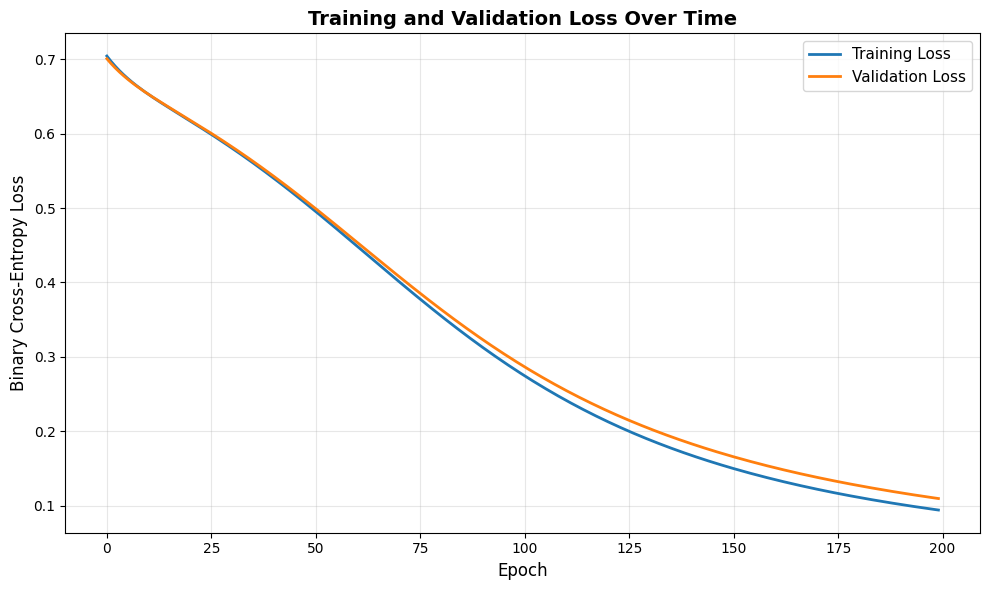

Final Training Loss: 0.0942
Final Validation Loss: 0.1097


In [318]:
# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss', linewidth=2)
plt.plot(val_losses, label='Validation Loss', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Binary Cross-Entropy Loss', fontsize=12)
plt.title('Training and Validation Loss Over Time', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Final Training Loss: {train_losses[-1]:.4f}")
print(f"Final Validation Loss: {val_losses[-1]:.4f}")

**What to look for in the plot**:
- Both losses should decrease over time ✅
- If validation loss starts increasing while training loss decreases → **overfitting**
- If both losses are still decreasing at the end → you could train longer
- If losses are very close → good generalization!

### Step 10: Evaluate Final Performance

Let's see how accurate our model is on the validation set.

In [319]:
# Make predictions on validation set
model.eval()
with torch.no_grad():
    val_predictions = model(X_val_tensor)
    # Convert probabilities to class predictions (threshold at 0.5)
    predicted_classes = (val_predictions >= 0.5).float()

# Calculate accuracy
correct = (predicted_classes == y_val_tensor).sum().item()
total = len(y_val_tensor)
accuracy = correct / total

print(f"Validation Accuracy: {accuracy:.2%} ({correct}/{total} correct)")

Validation Accuracy: 100.00% (20/20 correct)


---
## Summary: Key PyTorch Patterns for Deep Learning

Congratulations! You've learned the essential PyTorch workflow:

**1. PyTorch Basics**:
- Create tensors with `torch.tensor()`
- Enable gradient tracking with `requires_grad=True`
- Compute gradients with `.backward()`
- Update parameters in `with torch.no_grad():` block
- Always zero gradients with `.grad.zero_()`

**2. Neural Network Development**:
- Define architecture by subclassing `nn.Module`
- Implement `forward()` to define data flow
- Count parameters to understand model capacity
- Choose appropriate loss function (BCE for binary classification)
- Use optimizers to update parameters automatically

**3. Training Best Practices**:
- ✅ Split data into train/validation sets
- ✅ Normalize input features
- ✅ Track both training and validation loss
- ✅ Use `model.train()` and `model.eval()` modes
- ✅ Disable gradients during validation with `torch.no_grad()`
- ✅ Visualize training curves to diagnose issues

**Next steps**: In future notebooks, you'll learn about mini-batch training, different activation functions, advanced optimizers, and techniques to prevent overfitting!

---
## 🔧 Final Exercises: Experiment with the Model

Now it's your turn to experiment! Complete the following exercises to understand how different hyperparameters affect model performance.

In [320]:
# TODO: Copy and modify the model definition, training loop, and evaluation code here
# Change hidden_dim to 16 or 4



In [321]:
# TODO: Copy and modify the optimizer and training code here
# Try learning_rate = 0.01 or learning_rate = 0.5



In [322]:
# TODO: Copy and modify the training code here
# Change num_epochs to 500



In [323]:
# TODO: Copy and modify the model class here
# Replace self.activation1 = nn.Sigmoid() with nn.ReLU()
# Keep self.activation2 = nn.Sigmoid() for the output

